In [46]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt


In [50]:
# Data file names

grid_info = '../datasets/lisbon_ficheiros_WDL/ficheiros_WDL/DISPOSITIVOS MOVEIS_QUADRICULAS/DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx'

#There are mov files for different datas, I'll add all of them here latter 
movs = '../datasets/lisbon_ficheiros_WDL/ficheiros_WDL/DISPOSITIVOS MOVEIS_GRELHA E EIXOS/CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv'


In [48]:
df_movs = pd.read_csv(movs)

In [51]:
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['latitude', 'longitude', 'grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

In [52]:
# coordinates
lats = dfs_grid_filtered['latitude'].values
lons = dfs_grid_filtered['longitude'].values
# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

In [53]:
# The number of timestamps is the same for every grid point
timeStamps = df_movs.loc[df_movs['Grid_ID'] == 1]['Datetime']
nTimeStamps = len(timeStamps)

C1_movs = df_movs['C1']
C2_movs = df_movs['C2']
C3_movs = df_movs['C3']
C4_movs = df_movs['C4']
C5_movs = df_movs['C5']
C6_movs = df_movs['C6']
C7_movs = df_movs['C7']
C8_movs = df_movs['C8']

grelha_id_movs = df_movs['Grid_ID']

In [54]:
grelha_id_2d = np.zeros((grelha_y.max() +1, grelha_x.max()+1))
lat_2d = grelha_id_2d.copy()
lon_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])


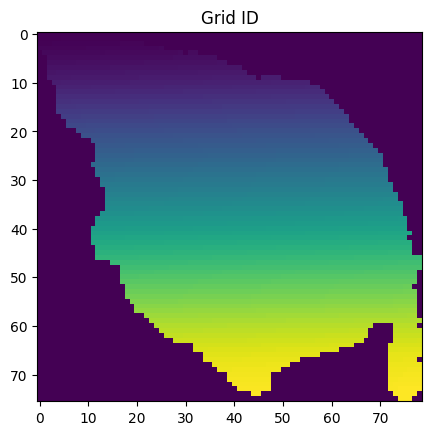

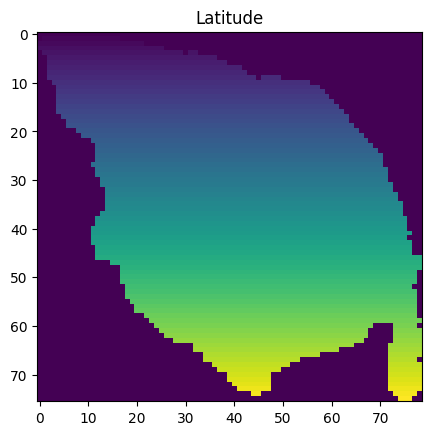

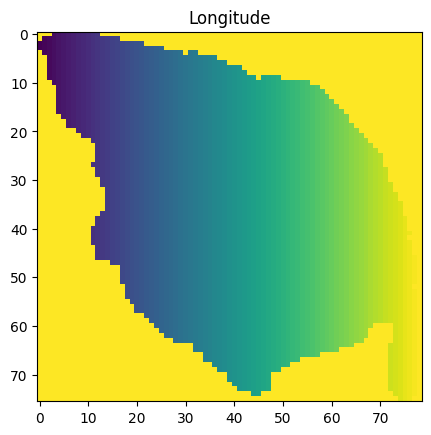

In [55]:
grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
lat_2d[tuple(idx_2d)] = lats.ravel()
lon_2d[tuple(idx_2d)] = lons.ravel()

plt.title('Grid ID')
plt.imshow(grelha_id_2d)
plt.show()

plt.title('Latitude')
plt.imshow(lat_2d, vmax = lats.max(), vmin = lats.min())
plt.show()

plt.title('Longitude')
plt.imshow(lon_2d, vmax = lons.max(), vmin = lons.min())
plt.show()



In [56]:
grelha_id_3d = np.repeat(grelha_id_2d[..., np.newaxis], nTimeStamps, axis=-1)
lat_3d = np.repeat(lat_2d[..., np.newaxis], nTimeStamps, axis=-1)
lon_3d = np.repeat(lon_2d[..., np.newaxis], nTimeStamps, axis=-1)

C1_grid = np.zeros_like(grelha_id_3d)
C2_grid = np.zeros_like(grelha_id_3d)
C3_grid = np.zeros_like(grelha_id_3d)
C4_grid = np.zeros_like(grelha_id_3d)
C5_grid = np.zeros_like(grelha_id_3d)
C6_grid = np.zeros_like(grelha_id_3d)
C7_grid = np.zeros_like(grelha_id_3d)
C8_grid = np.zeros_like(grelha_id_3d)

In [57]:
# This can takes some time (~2.5 min) because it is not vectorized ... Anyway we can do it once and store it ...
# Anyway doing it will xarray will be simpler 

for id in np.unique(grelha_id_movs):
    try:
        mask = grelha_id_3d == id
        C1_grid[mask] = C1_movs[(id-1)*nTimeStamps:id*nTimeStamps]
        C2_grid[mask] = C2_movs[(id-1)*nTimeStamps:id*nTimeStamps]
        C3_grid[mask] = C3_movs[(id-1)*nTimeStamps:id*nTimeStamps]
        C4_grid[mask] = C4_movs[(id-1)*nTimeStamps:id*nTimeStamps]
        C5_grid[mask] = C5_movs[(id-1)*nTimeStamps:id*nTimeStamps]
        C6_grid[mask] = C6_movs[(id-1)*nTimeStamps:id*nTimeStamps]
        C7_grid[mask] = C7_movs[(id-1)*nTimeStamps:id*nTimeStamps]
        C8_grid[mask] = C8_movs[(id-1)*nTimeStamps:id*nTimeStamps]
    except:
        print(f'Grid element with id {id} not being assigned!')

Grid element with id 89 not being assigned!


In [41]:
#del(df_movs)

# Full array of data:
data = np.stack([grelha_id_3d, lat_3d, lon_3d, C1_grid, C2_grid, C3_grid, C4_grid, C5_grid, C6_grid, C7_grid, C8_grid], axis = -1)

# The shape should be (y,x,timeStamp,var)
data.shape

(76, 79, 2832, 11)

In [42]:
# Save data the data array:
# Currently takes 1.5GB
with open('data.npy', 'wb') as f:
    np.save(f, data)

In [ ]:
# Loading it ...
with open('data.npy', 'rb') as f:
    data = np.load(f)

**OPTION 2: Xarray dataset:**

(I'll do this one later)

In [191]:
import xarray as xr